### Data Selections
- How do we make the baseline to decide which data we should exclude? 
- What is the conditions of selecting data
- Mostly data are under 10 (forks count, stargazers...)


### Big Query
- We need to get the package that the code used, any specific kind of programming language?
- How can we get the company financial report? 
- What company should we look for?
- If the repo that big query contains do not have those repo that have high forks, what should we do?

In [ ]:
import requests
import time
import json
import pprint
import pickle
import pandas as pd
import base64
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

### Get Big Query Data 

In [2]:
bq = pd.read_csv('bq-results-20191018-123202-zboc6qrkl2p8.csv')
# sort bq by repo_name
bq.sort_values('repo_name')

finalList = set(bq['repo_name'])
finalList = list(finalList)

### Create dataframe 

In [3]:
colnames = ['repo_name', 'description', 'created_at', 'pushed_at', 'forks_count', 'stargazers_count',
          'subscribers_count', 'open_issues_count', 'organization_name','topics','pulls_count', 'commits_count', 'branches_count',
           'releases_count', 'contributors_count', 'last_commit_time', 'readme', 'language']

deeplearning_df = pd.DataFrame(columns = colnames)  

### Get more information using github API

In [ ]:
# -- save picle        
filepath = 'DeepLearning_bq.pkl'

def batch(repo_list):
    
    with open(filepath, 'ab') as f:
        pickle.dump(repo_list, f)
# ==== repo ==== 

for x in range(len(finalList)):
    
    page_commit = 1
    commit = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/commits?page='+str(page_commit)+'&per_page=100',auth = ('elletsai', '0f5c16b728f522f5b19c17c8981b8b9d51619df3'))
    commit_json = json.loads(commit.text)
    if (type(commit_json) is dict):
        continue
    else:
        repoInfo = requests.get('http://api.github.com/repos/'+finalList[x] ,auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'))
        repoInfo_json = json.loads(repoInfo.text)
        repo_query_list = ['full_name', 'description', 'created_at', 'pushed_at', 'forks_count', 'stargazers_count',
                  'subscribers_count', 'open_issues_count']

        repo_tuple = tuple(repoInfo_json[x] for x in repo_query_list)

        try: 
            login = repoInfo_json['organization']['login']

        except KeyError:
            login = 'None'

        repo_tuple += (login,)

        # === topic ==
    headers = {"Accept":"application/vnd.github.mercy-preview+json"}
    page_topic = 1
    topic_list = []
    while True:
        topic = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/topics?page='+str(page_topic)+'&per_page=100',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'),headers = headers)
        topic_json = json.loads(topic.text)

        if len(topic_json['names']) == 0:
            if page_topic is 1:
                topic_list = ['None']
                topic_list = ''.join(map(str, topic_list))            
            break

        topic_list += topic_json['names']
        topic_list = ','.join(map(str, topic_list))
        page_topic += 1


    repo_tuple += tuple([topic_list],)
    

    
    # === pull request ===

    repo_name = 'NVIDIA/DIGITS'
    page_pull = 1
    pull_num = 0
    pull_headers = {"Accept":"application/vnd.github.shadow-cat-preview+json"}
    while True:
        pull = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/pulls?page='+str(page_pull)+'&per_page=100',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'),headers = pull_headers)
        pull_json = json.loads(pull.text)

        if len(pull_json) == 0:
            break
        pull_num += len(pull_json)
        page_pull += 1



    repo_tuple += tuple([pull_num],)

    
    # === commits count ===
    page_commit = 1
    commit_num = 0
    while True:
        commit = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/commits?page='+str(page_commit)+'&per_page=100',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'))
        commit_json = json.loads(commit.text)

        if len(commit_json) == 0:
            break
        commit_num += len(commit_json)
        page_commit += 1

    repo_tuple += tuple([commit_num],)

    
    # === branch count ===
    page_branch = 1
    branch_num = 0
    while True:
        branch = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/branches?page='+str(page_branch)+'&per_page=100',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'))
        branch_json = json.loads(branch.text)

        if len(branch_json) == 0:
            break
        branch_num += len(branch_json)
        page_branch += 1

    repo_tuple += tuple([branch_num],)

    
    # === release count ===
    page_release = 1
    release_num = 0
    while True:
        release = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/releases?page='+str(page_release)+'&per_page=100',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'))
        release_json = json.loads(release.text)

        if len(release_json) == 0:
            break
        release_num += len(release_json)
        page_release += 1

    repo_tuple += tuple([release_num],)
    repo_tuple


    
    # === contributors count ===
    page_contributor = 1
    contributor_num = 0
    while True:
        contributor = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/contributors?page='+str(page_contributor)+'&per_page=100',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'))
        contributor_json = json.loads(contributor.text)

        if len(contributor_json) == 0:
            break
        contributor_num += len(contributor_json)
        page_contributor += 1

    repo_tuple += tuple([contributor_num],)
    

    
    # === most recent commit time ===

    page_commit_time = 1

    commit_time = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/commits?page='+str(page_commit_time)+'&per_page=100',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'))
    commit_time_json = json.loads(commit_time.text)
    commit_time = commit_time_json[0]['commit']['committer']['date']
    repo_tuple += (commit_time,)

    # === readme ===
    try: 
        readme = requests.get('https://api.github.com/repos/'+finalList[x]+'/readme',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'))
        readme_json = json.loads(readme.text)
        readme_content = base64.b64decode(readme_json['content'])

    except KeyError:
        readme_content = 'None'

    repo_tuple += (readme_content,)


    
    # === language ====
    page_lang = 1
    lang_list = []


    lang = requests.get('http://api.github.com/repos/'+str(finalList[x])+'/languages?page='+str(page_lang)+'&per_page=100',auth = ('hannahxchen', 'd03c1716e3015b04bb8e3f813bc04276c8e06ea3'),headers = headers)
    lang_json = json.loads(lang.text)

    lang_list = ','.join(map(str, lang_json.keys()))
    page_lang += 1
    repo_tuple += tuple([lang_list],)

    
    # === import to df =====

    print(x)
    batch(repo_tuple)

    
    # -- save to df
    deeplearning_df = deeplearning_df.append(pd.Series(repo_tuple, index=deeplearning_df.columns ), ignore_index=True)
    
    
    time.sleep(2)

# save to csv
deeplearning_df.to_csv('DeepLearning_bq.csv', sep = '\t')

## Get data from "DeepLearning_bq.csv"

In [2]:
deeplearning_df = pd.read_csv('DeepLearning_bq.csv', sep = '\t').drop(columns = ['Unnamed: 0'])
deeplearning_df.head(3)

,repo_name,description,created_at,pushed_at,forks_count,stargazers_count,subscribers_count,open_issues_count,organization_name,topics,pulls_count,commits_count,branches_count,releases_count,contributors_count,last_commit_time,readme,language
0,rafaeltg/pydl,Deep Learning algorithms implemented using Ker...,2016-07-24 17:29:21+00:00,2017-10-27 21:34:33+00:00,0,2,1,0,None,None,0,108,1,0,1,2017-10-27 21:34:24+00:00,b'# Deep Learning algorithms with Keras librar...,Python
1,zchq88/MyUdacityDeepLearningProject,My Udacity Deep Learning Project,2017-01-31 02:43:41+00:00,2017-05-16 08:41:24+00:00,0,0,1,0,None,None,0,20,1,0,1,2017-05-16 08:40:25+00:00,None,"HTML,Jupyter Notebook,Python"
2,fablln/Deep-Learning,Repository containing the laboratories of the ...,2017-03-30 22:01:29+00:00,2017-06-05 09:31:49+00:00,0,0,1,0,None,"neural-network,deep-learning,deep-neural-netwo...",0,11,1,0,1,2017-06-05 09:31:42+00:00,b'# Deep-Learning\nRepository containing the l...,"Jupyter Notebook,HTML,Python"


In [3]:
deep_num = deeplearning_df.iloc[:, [4, 5, 6, 7, 10, 11, 12,13, 14]]
deep_num.head(3)

,forks_count,stargazers_count,subscribers_count,open_issues_count,pulls_count,commits_count,branches_count,releases_count,contributors_count
0,0,2,1,0,0,108,1,0,1
1,0,0,1,0,0,20,1,0,1
2,0,0,1,0,0,11,1,0,1


## Data Visualization

### Frequencies Count
- fork, stargazers, subscribers bigger the more influential the repo is

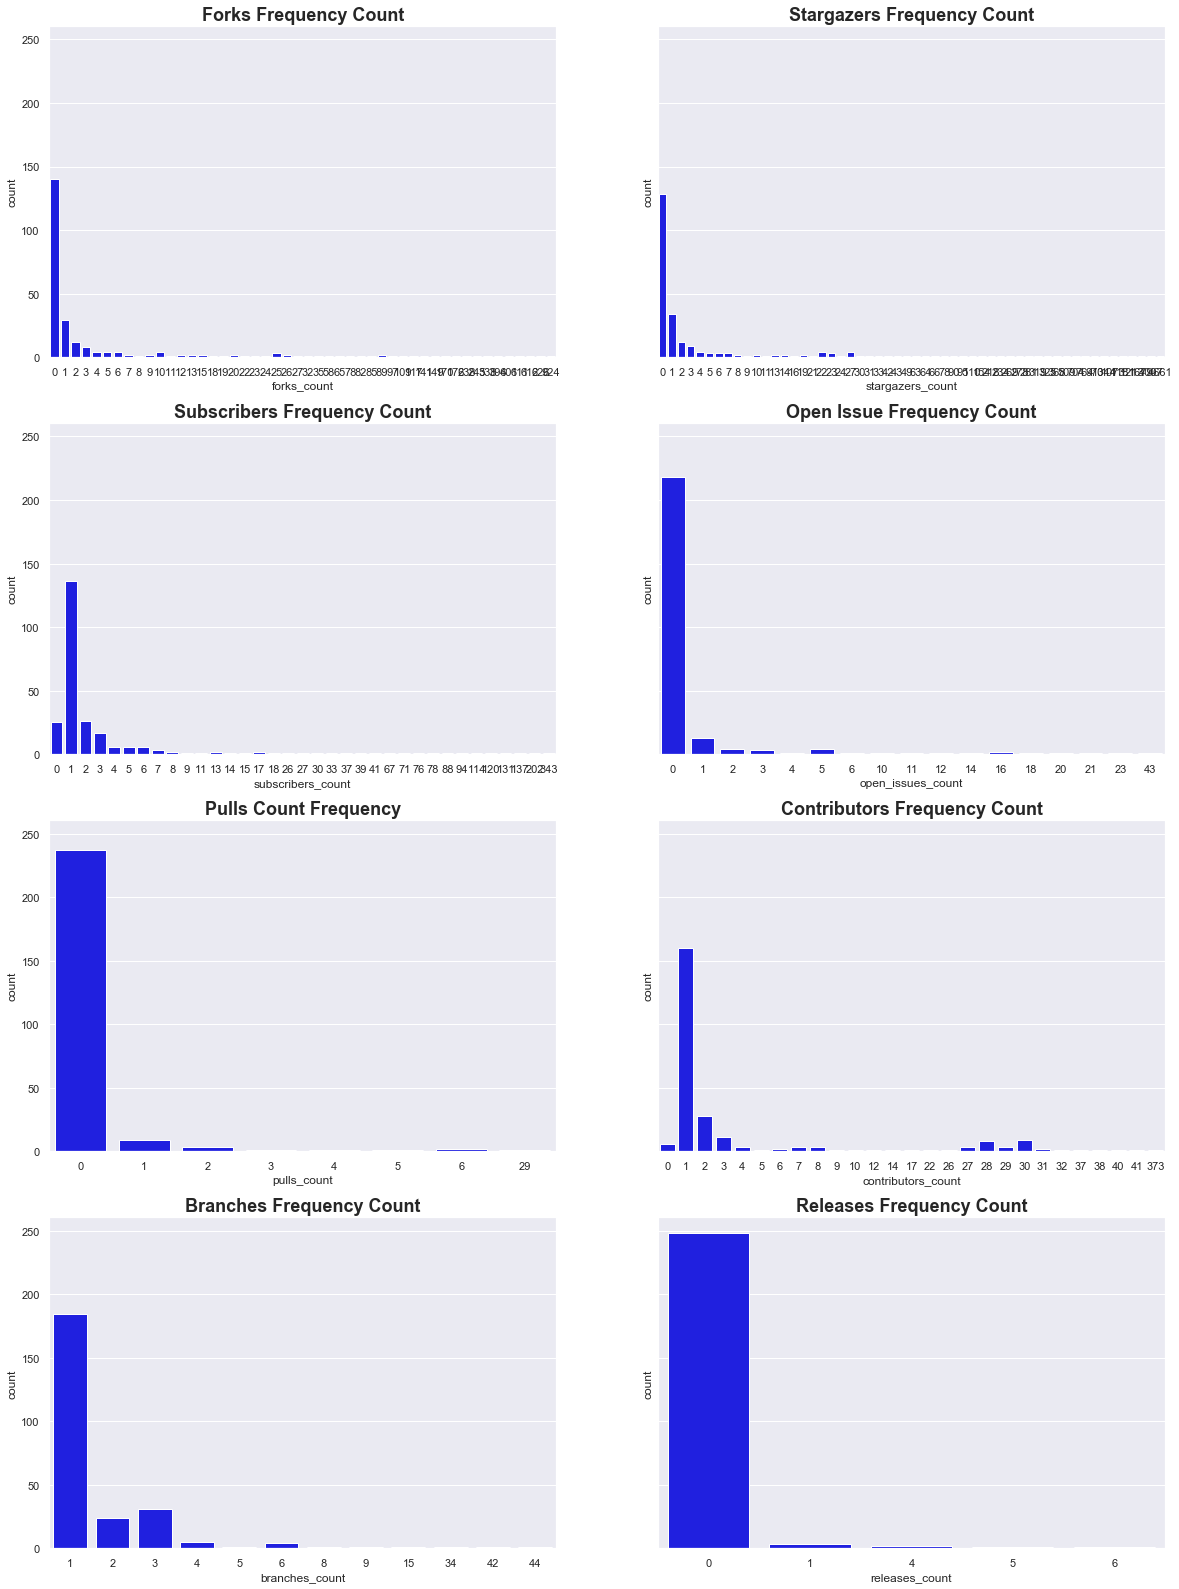

In [25]:
sns.set(style="darkgrid")
a_dims = (20, 28)
fig, ((ax1, ax2), (ax3, ax4),
      (ax5, ax6), (ax7, ax8)) = plt.subplots(figsize=a_dims,
                                         ncols=2,
                                         nrows = 4, 
                                         sharey=True)
                                         

# -- Graph
sns.set(style="darkgrid")
a1 = sns.countplot(x= "forks_count", data=deeplearning_df, color = 'blue', ax = ax1)
a2 = sns.countplot(x= "stargazers_count", data=deeplearning_df, color = 'blue', ax = ax2)
a3 = sns.countplot(x= "subscribers_count", data=deeplearning_df, color = 'blue',ax = ax3)
a4 = sns.countplot(x= "open_issues_count", data=deeplearning_df, color = 'blue', ax = ax4)
a5 = sns.countplot(x= "pulls_count", data=deeplearning_df, color = 'blue', ax = ax5)
a6 = sns.countplot(x= "contributors_count", data=deeplearning_df, color = 'blue', ax = ax6)
a7 = sns.countplot(x= "branches_count", data=deeplearning_df, color = 'blue', ax = ax7)
a8 = sns.countplot(x= "releases_count", data=deeplearning_df, color = 'blue', ax = ax8)

titles = ['Forks Frequency Count', 'Stargazers Frequency Count', 'Subscribers Frequency Count','Open Issue Frequency Count',
        'Pulls Count Frequency', 'Contributors Frequency Count', 'Branches Frequency Count','Releases Frequency Count']

a = [a1, a2, a3, a4, a5, a6, a7, a8]

# -- set title to each subplot
for (ai, title) in zip(a,titles):
    
    ai.set_title(title, fontsize = 18, fontweight = 'bold')


### Commit Count

Text(0.5, 1.0, 'Commit Frequency Count')

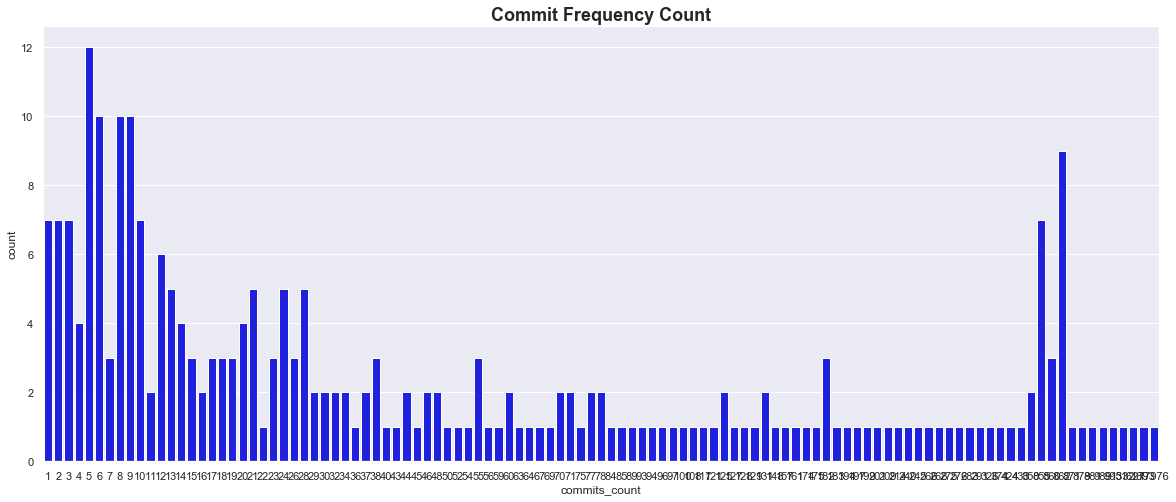

In [448]:
a4_dims = (20, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set(style="darkgrid")

ax = sns.countplot(x= "commits_count", data=deeplearning_df, color = 'blue')
ax.set_title('Commit Frequency Count', fontsize = 18, fontweight = 'bold')

### See which year has more repo pushed

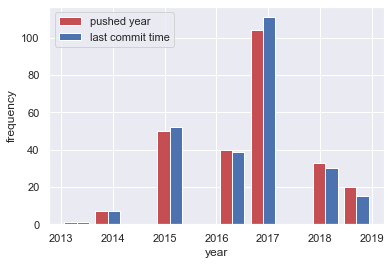

In [321]:
# covert column to date time
deeplearning_df[["created_at", "pushed_at", "last_commit_time"]] = deeplearning_df[["created_at", "pushed_at", "last_commit_time"]].apply(pd.to_datetime)

# see which year has more people pushed deep learning repo
push_year = deeplearning_df['pushed_at'].dt.year
last_commit_time = deeplearning_df['last_commit_time'].dt.year
plt.hist([push_year, last_commit_time], color=['r','b'], alpha=1, label = ('pushed year', 'last commit time'))
plt.xlabel('year') 
plt.ylabel('frequency')
plt.legend()

- There were very little of the porportion that pushed the repo in 2013. Therefore, we can drop the repo that was pushed that year<br>
- Repo is published after pushed, therefore neglect created time

### What language that most people used for deep learning?

In [41]:
language_list = list(deeplearning_df['language'])
language = str(language_list)

In [287]:
# remove symbols in string
import re
l = re.sub(r'[^\w]', ' ', language)

# calculate each language frequency count
from collections import Counter

# see top 10 frequent language
Counter(l.split()).most_common(10)

[('Python', 156),
 ('Jupyter', 75),
 ('Notebook', 75),
 ('Shell', 50),
 ('HTML', 38),
 ('C', 38),
 ('MATLAB', 14),
 ('JavaScript', 12),
 ('CSS', 12),
 ('Makefile', 11)]

## See Repo Content

In [30]:
# count how many times do this file import package
bq = ['content'][0].count('import')

7

In [4]:
import nltk
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


### See occurance using NLTK

In [112]:
t = nltk.tokenize.WhitespaceTokenizer()
c = Text(t.tokenize(bq['content'][16]))
c.concordance(u'import')


Displaying 4 of 4 matches:
: [], "source": [ "from collections import Counter\n", "import numpy as np" ] 
, "source": [ "from IPython.display import Image\n", "\n", "review = \"This wa
, "source": [ "from IPython.display import Image\n", "Image(filename='sentimen
, "source": [ "from IPython.display import Image\n", "Image(filename='sentimen


### Get package ( search for word after import)

In [92]:
import re
s = bq['content'][3]
q = 'import'


def get_package(data):
    package_index = [m.start() for m in re.finditer('import', data)]
    return [data[p+len(q):].split()[0] for p in package_index]

In [115]:
get_package(bq['content'][16])

['Counter\\n",',
 'numpy',
 "ant',",
 "ance',",
 'Image\\n",',
 'numpy',
 'Image\\n",',
 'time\\n",',
 'sys\\n",',
 'numpy',
 'Image\\n",',
 'time\\n",',
 'sys\\n",',
 'numpy']

## Read dl_infor from all data scrape for deep learning
'deep learning' and 'dl'

In [68]:
import pickle
import pandas as pd
data = []
with open('dl_info.pkl', 'rb') as fr:
    try:
        while True:
            data.append(pickle.load(fr))
    except EOFError:
        pass
dl_info = pd.DataFrame(data,columns=colnames)
dl_info.tail(3)



,repo_name,description,created_at,pushed_at,forks_count,stargazers_count,subscribers_count,open_issues_count,organization_name,topics,pulls_count,commits_count,branches_count,releases_count,contributors_count,last_commit_time,readme,language
31546,VSainteuf/deep-lecture,Materials for lecture on deep learning,2019-03-11T09:36:26Z,2019-03-11T17:43:09Z,0,0,0,0,None,None,0,2,1,0,1,2019-03-11T19:41:54Z,None,Jupyter Notebook
31547,jnpalmstrom/cs4518FinalProject,Mobile Final Project revolving around deep-lea...,2018-11-30T18:43:31Z,2018-12-13T18:11:38Z,0,0,1,0,None,None,0,16,2,0,2,2018-12-13T18:11:25Z,b'# cs4518FinalProject\nMobile Final Project r...,Java
31548,gooselinux/mingw32-dlfcn,Implements a wrapper for dlfcn (dlopen dlclose...,2011-12-28T02:21:56Z,2012-05-01T06:37:51Z,0,1,5,0,gooselinux,None,0,1,1,0,1,2012-05-01T06:37:47Z,None,


In [144]:
dl_info_num = dl_info.iloc[:, [4, 5, 6, 7, 10, 11, 12,13, 14]]
dl_info_num.describe()

,forks_count,stargazers_count,subscribers_count,open_issues_count,pulls_count,commits_count,branches_count,releases_count,contributors_count
count,31549.000000,31549.000000,31549.000000,31549.000000,31549.000000,31549.000000,31549.000000,31549.000000,31549.000000
mean,5.385464,17.156677,2.155155,0.527434,0.089004,56.255476,1.263875,0.088719,1.740943
std,128.700936,478.690105,29.276528,18.848240,3.385665,2668.792288,1.929007,2.050682,10.883132
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,16.000000,1.000000,0.000000,1.000000
max,10488.000000,57182.000000,2342.000000,3094.000000,542.000000,461470.000000,134.000000,279.000000,436.000000


In [186]:
print('forks > 100: ',len(dl_info[dl_info['forks_count'] > 100]))
print('stargazers > 100: ', len(dl_info[dl_info['stargazers_count'] > 100]))
print('subscribers > 100: ', len(dl_info[dl_info['subscribers_count'] > 100]))
print('open_issues > 100: ', len(dl_info[dl_info['open_issues_count'] > 100]))
print('pulls > 100: ', len(dl_info[dl_info['pulls_count'] > 100]))
print('commits > 100: ', len(dl_info[dl_info['commits_count'] > 100]))
print('branches > 100: ', len(dl_info[dl_info['branches_count'] > 100]))
print('releases > 100: ', len(dl_info[dl_info['releases_count'] > 100]))
print('contributors > 100: ', len(dl_info[dl_info['contributors_count'] > 100]))




forks > 100:  202
stargazers > 100:  396
subscribers > 100:  79
open_issues > 100:  17
pulls > 100:  2
commits > 100:  1383
branches > 100:  3
releases > 100:  2
contributors > 100:  47


- If subscribers > 100, then the number of stargazers of that repo is also greater than 100

In [240]:
# get repo that fork is greater than 100, but stargazers is not
a = pd.DataFrame(dl_info['stargazers_count'][dl_info['forks_count'] > 100] < 100)
index = a[a['stargazers_count'] == True].index
dl_info.iloc[index,:]

,repo_name,description,created_at,pushed_at,forks_count,stargazers_count,subscribers_count,open_issues_count,organization_name,topics,pulls_count,commits_count,branches_count,releases_count,contributors_count,last_commit_time,readme,language
1733,udacity/aind2-dl,None,2017-05-08T02:29:48Z,2018-03-30T04:26:53Z,181,33,12,6,udacity,None,3,21,2,0,4,2017-12-05T21:15:21Z,b'# aind2-dl\n\n### Instructions\n\n1. Clone t...,Jupyter Notebook
5964,acgd-webdev-2/hot-grid-dle,"Create a small layout using grids, hiding and ...",2018-01-23T21:00:26Z,2019-01-25T20:20:10Z,124,0,1,0,acgd-webdev-2,None,0,4,1,0,1,2019-01-25T20:20:01Z,"b""---\nsummary: 'Create a small layout using g...",
8952,pombredanne/udemy-dl,Udemy free video downloader,2013-11-02T23:21:43Z,2015-10-07T02:04:34Z,108,2,3,1,None,None,1,2,1,0,1,2013-02-02T23:13:53Z,b'A script to download downloadable lectures f...,
12078,soumyadsanyal/foundations_for_deep_learning,Building a foundation for deep learning with m...,2017-05-29T07:34:21Z,2017-05-28T16:20:26Z,268,22,5,0,None,None,0,10,1,0,1,2017-05-28T16:20:21Z,b'# foundations for deep learning:\n1. I empha...,
12726,udacity/RoboND-DeepLearning-Project,"RoboND Term 1 Deep Learning Project, Follow-Me",2017-09-15T17:26:46Z,2017-12-19T04:49:42Z,197,47,24,3,udacity,None,0,20,2,6,6,2017-12-19T04:49:42Z,b'[![Udacity - Robotics NanoDegree Program](ht...,"Python,Jupyter Notebook"
21640,DeepLearningDTU/02456-deep-learning-with-PyTorch,Exercises and supplementary material for the d...,2018-08-26T07:44:21Z,2019-10-27T20:50:05Z,104,70,18,5,DeepLearningDTU,None,1,101,5,0,10,2019-10-27T20:50:04Z,b'# 02456-deep-learning-with-PyTorch\n\nThis r...,"Jupyter Notebook,Python,Shell"
24765,SmartThingsUle/DLNA-PLAYER,Generic DLNA Player to Smartthings,2015-02-13T00:22:07Z,2018-10-13T07:50:14Z,254,96,57,15,None,None,3,171,1,0,1,2018-10-13T07:50:13Z,b'# DLNA-PLAYER \nGeneric DLNA Player to Smart...,Groovy


In [ ]:
# commits > 100, and stargazers is also >100
sum(dl_info['stargazers_count'][dl_info['commits_count'] > 100] > 100)

In [69]:
# get repo that has organization
dl_info[dl_info['organization_name'] != 'None'].head(3)

,repo_name,description,created_at,pushed_at,forks_count,stargazers_count,subscribers_count,open_issues_count,organization_name,topics,pulls_count,commits_count,branches_count,releases_count,contributors_count,last_commit_time,readme,language
8,sical/Data-Visualization-with-Deep-Learning,The last results of deep learning researches h...,2017-01-12T12:26:55Z,2018-06-01T07:52:23Z,3,6,5,0,sical,None,0,145,1,0,2,2018-06-01T07:52:22Z,b'# Data-Visualization-with-Deep-Learning\n\nT...,"JavaScript,Python,HTML,CSS"
13,cchmc-dll/ai_preproc,Preprocessing pipeline for Deep Learning LAB,2019-08-09T15:22:23Z,2019-10-02T20:47:17Z,0,0,1,0,cchmc-dll,None,0,31,1,0,1,2019-10-02T20:47:04Z,b'# ai_preproc\nPreprocessing pipeline for Dee...,"Python,Jupyter Notebook,Dockerfile"
14,machine-learning-experiments/deep-learning-not...,doing,2018-03-19T21:07:39Z,2018-03-19T22:13:51Z,0,0,0,0,machine-learning-experiments,None,0,3,1,0,0,2018-03-19T22:13:45Z,b'[![License](http://img.shields.io/:license-m...,


### Convert value into range

In [71]:

dl_info['forks_status'] = pd.cut(dl_info['forks_count'], bins=[-1, 5, 10, 50, 100, max(dl_info['forks_count'])], labels=False)
labels = np.array('0-5 5-10 10-50 50-100 100-max'.split())
dl_info['forks_status'] = labels[dl_info['forks_status']]
dl_info.head(3)

,repo_name,description,created_at,pushed_at,forks_count,stargazers_count,subscribers_count,open_issues_count,organization_name,topics,pulls_count,commits_count,branches_count,releases_count,contributors_count,last_commit_time,readme,language,forks_status
0,drafting-dreams/DeepLearningCourse2Week1,None,2018-02-21T08:07:54Z,2018-02-21T08:10:05Z,0,0,0,0,None,None,0,1,1,0,1,2018-02-21T08:08:21Z,None,"Jupyter Notebook,Python",0-5
1,patirasam/Deep-Learning-CNN-Text-Prediction,Aim of this project is to learn how text proce...,2018-03-26T21:19:34Z,2018-03-31T17:57:23Z,0,0,0,0,None,None,0,8,1,0,1,2018-03-31T17:57:22Z,b'# Machine-Learning-CNN-Text-Prediction\nAim ...,Python,0-5
2,lendenmc/ifskills-dl,Command line program to download training cour...,2016-09-26T20:21:47Z,2016-12-07T08:45:19Z,0,1,0,4,None,"python3,beautifulsoup,video-lecture,requests,c...",0,40,1,5,1,2016-12-02T10:15:53Z,"b""# Ifskills-dl\n\n## https://learn.infinites...",Python,0-5


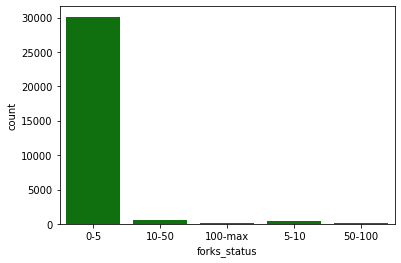

In [53]:
sns.countplot(x= "forks_status", data=dl_info, color = 'green')

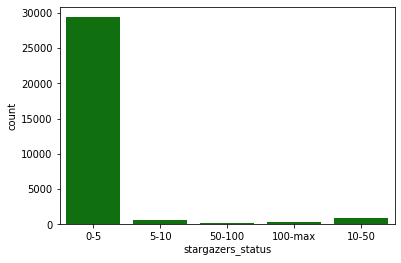

In [54]:
dl_info['stargazers_status'] = pd.cut(dl_info['stargazers_count'], bins=[-1, 5, 10, 50, 100, max(dl_info['stargazers_count'])], labels=False)
labels = np.array('0-5 5-10 10-50 50-100 100-max'.split())
dl_info['stargazers_status'] = labels[dl_info['stargazers_status']]
sns.countplot(x= "stargazers_status", data=dl_info, color = 'green')


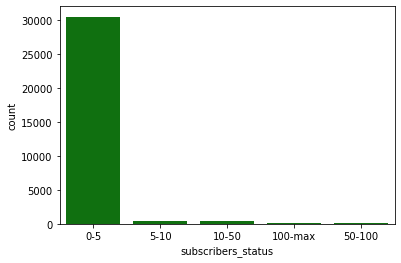

In [55]:
dl_info['subscribers_status'] = pd.cut(dl_info['subscribers_count'], bins=[-1, 5, 10, 50, 100, max(dl_info['subscribers_count'])], labels=False)
labels = np.array('0-5 5-10 10-50 50-100 100-max'.split())
dl_info['subscribers_status'] = labels[dl_info['subscribers_status']]
sns.countplot(x= "subscribers_status", data=dl_info, color = 'green')


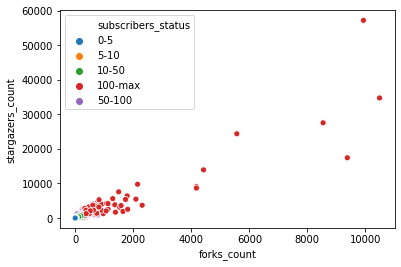

In [64]:
sns.scatterplot(x = 'forks_count', y = 'stargazers_count', data = dl_info, hue = 'subscribers_status')

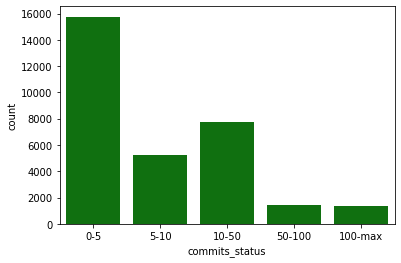

In [66]:
dl_info['commits_status'] = pd.cut(dl_info['commits_count'], bins=[-1, 5, 10, 50, 100, max(dl_info['commits_count'])], labels=False)
labels = np.array('0-5 5-10 10-50 50-100 100-max'.split())
dl_info['commits_status'] = labels[dl_info['commits_status']]
sns.countplot(x= "commits_status", data=dl_info, color = 'green')
plt.title = ('Commits')

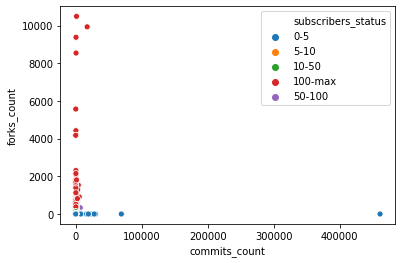

In [67]:
sns.scatterplot(x = 'commits_count', y = 'forks_count', data = dl_info, hue = 'subscribers_status')

- We can see that even even though commits number is low, forks count could be high. Therefore, commits cannot indicate that the repo is more influential <br> 
- We can see that there are many outliers. 
> 1. Get all the outliers, and exclude them to do other analysis <br>
> 2. What is the basline? 100?